In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Resizing,Rescaling,Conv2D,Flatten,BatchNormalization,MaxPool2D,Dropout,InputLayer,Dense,RandomContrast,RandomRotation,RandomFlip
from keras.regularizers import L2
from keras.metrics import CategoricalAccuracy ,TopKCategoricalAccuracy
from keras.optimizers import Adam
import cv2

In [75]:
train_directory="/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train"
validation_directory="/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES=["angry","happy","sad"]
CONFIGURATION={
        "BATCH_SIZE":32,
        "IMG_SIZE":256,
        "REGULARIZATION_RATE": 0.0,
      "N_FILTERS": 6,
      "KERNEL_SIZE": 3,
      "N_STRIDES": 1,
      "POOL_SIZE": 2,
      "N_DENSE_1": 100,
      "N_DENSE_2": 10,
    "DROPOUT_RATE": 0.0,
    "NUM_CLASSES":3,
    "LEARNING_RATE":0.001,
    "EPOCHS":10,
"CLASS_NAMES":["angry","happy","sad"]
    

}

In [59]:
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMG_SIZE"],CONFIGURATION["IMG_SIZE"]),
    shuffle=True,
    seed=42,
  
    
)


Found 6799 files belonging to 3 classes.


In [60]:
val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IMG_SIZE"],CONFIGURATION["IMG_SIZE"]),
    shuffle=True,
    seed=42,
)


Found 2278 files belonging to 3 classes.


In [5]:
for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 18.       ,  18.       ,  18.       ],
         [ 20.4375   ,  20.4375   ,  20.4375   ],
         [ 23.0625   ,  23.0625   ,  23.0625   ],
         ...,
         [  4.3125   ,   4.3125   ,   4.3125   ],
         [  5.375    ,   5.375    ,   5.375    ],
         [  7.       ,   7.       ,   7.       ]],

        [[ 12.3125   ,  12.3125   ,  12.3125   ],
         [ 13.4296875,  13.4296875,  13.4296875],
         [ 14.6328125,  14.6328125,  14.6328125],
         ...,
         [  4.3125   ,   4.3125   ,   4.3125   ],
         [  5.375    ,   5.375    ,   5.375    ],
         [  7.       ,   7.       ,   7.       ]],

        [[ 13.75     ,  13.75     ,  13.75     ],
         [ 14.003906 ,  14.003906 ,  14.003906 ],
         [ 13.8046875,  13.8046875,  13.8046875],
         ...,
         [  4.3125   ,   4.3125   ,   4.3125   ],
         [  5.5039062,   5.5039062,   5.5039062],
         [  7.6875   ,   7.6875   ,   7.6875

# Dataset Visualization

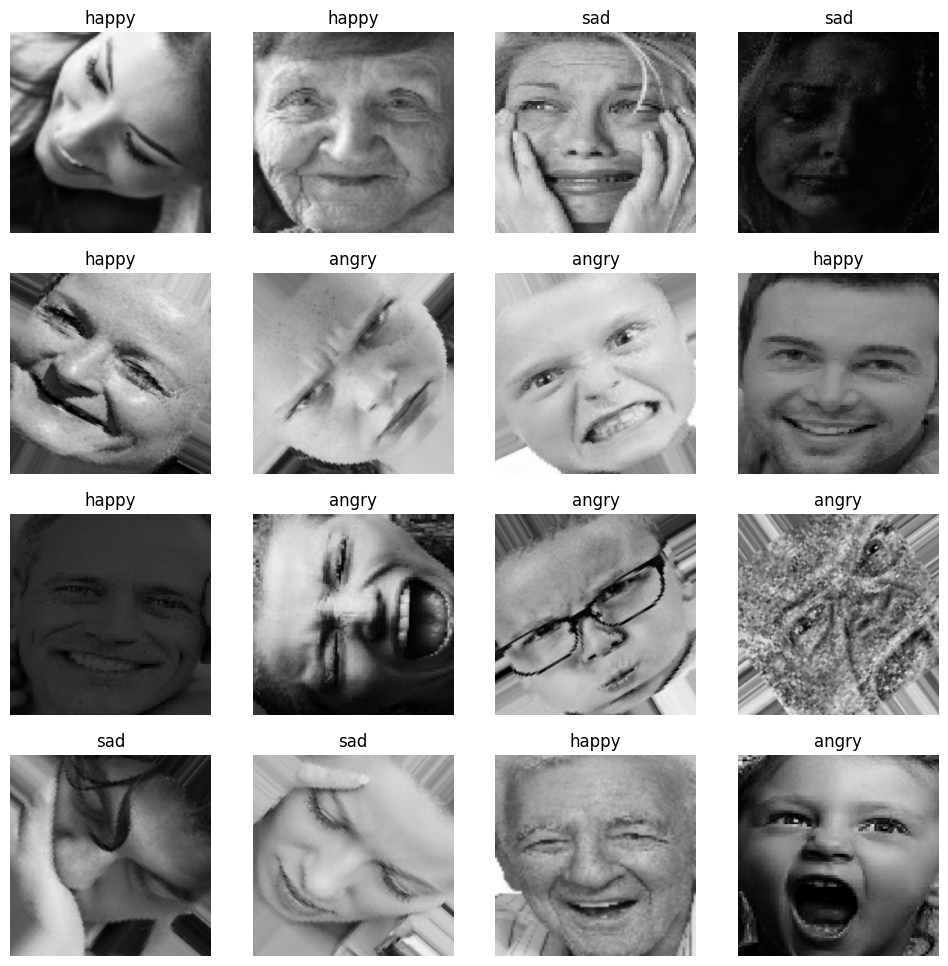

In [5]:
plt.figure(figsize=(12,12))
for images,labels in train_dataset.take(1):
    for i in range(16):
        po=plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title(CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()])
        plt.axis("off")
        
        

 # Data Augmentation

In [56]:
def box(lamda):
  
    r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IMG_SIZE"]).sample(1)[0], dtype = tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IMG_SIZE"]).sample(1)[0], dtype = tf.int32)

    r_w = tf.cast(CONFIGURATION["IMG_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
    r_h = tf.cast(CONFIGURATION["IMG_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

    r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IMG_SIZE"])
    r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IMG_SIZE"])

    x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IMG_SIZE"])
    y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IMG_SIZE"])

    r_w = x_b_r - r_x
    if(r_w == 0):
        r_w  = 1

    r_h = y_b_r - r_y
    if(r_h == 0):
        r_h = 1

    return r_y, r_x, r_h, r_w

In [54]:
def cutmix(train_dataset_1, train_dataset_2):
    (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

    lamda = tfp.distributions.Beta(2,2)
    lamda = lamda.sample(1)[0]

    r_y, r_x, r_h, r_w = box(lamda)
    crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
    pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IMG_SIZE"], CONFIGURATION["IMG_SIZE"])

    crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
    pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IMG_SIZE"], CONFIGURATION["IMG_SIZE"])

    image = image_1 - pad_1 + pad_2

    lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IMG_SIZE"]*CONFIGURATION["IMG_SIZE"]), dtype = tf.float32)
    label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

    return image, label

In [61]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [62]:
train_dataset=(
    mixed_dataset
    .map(cutmix,num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

#### > So, in summary, the line train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE) is optimizing your training data pipeline by prefetching batches of data in the background while the model is training, potentially reducing training time by keeping the GPU or CPU busy with data processing tasks.

In [63]:
validation_dataset=(
    val_dataset.prefetch(tf.data.AUTOTUNE)
)

In [19]:
resize_rescale_layers=tf.keras.Sequential([
    Resizing(CONFIGURATION["IMG_SIZE"],CONFIGURATION["IMG_SIZE"]),
    Rescaling(1./255)
])

# <b>Modeling<b>
    

In [34]:
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']
lenet_model=tf.keras.Sequential(
[
    InputLayer(input_shape=(None,None,3)),
    resize_rescale_layers,
    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),
    
    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(3, activation = "softmax"),
    
    
    
]
)
lenet_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 254, 254, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 125, 125, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     6,150,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,153,119 (23.47 MB)

 Trainable params: 6,152,855 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

## <b> Training <b>
    
    

In [35]:
loss_function=tf.keras.losses.CategoricalCrossentropy(
  
)


In [36]:
metrics=[CategoricalAccuracy(name="accuracy"),TopKCategoricalAccuracy(k=2,name="top_K_accuracy")]

In [64]:
lenet_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss=loss_function,
    metrics=metrics
)


In [65]:
history=lenet_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=CONFIGURATION['EPOCHS'],
    verbose=1
)

Epoch 1/10
  5/213 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.3568 - loss: 1.6426 - top_K_accuracy: 0.6471

W0000 00:00:1711819985.181422      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.4292 - loss: 1.1638 - top_K_accuracy: 0.7441

W0000 00:00:1711820048.726728      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


213/213 ━━━━━━━━━━━━━━━━━━━━ 74s 309ms/step - accuracy: 0.4294 - loss: 1.1633 - top_K_accuracy: 0.7442 - val_accuracy: 0.4416 - val_loss: 1.0685 - val_top_K_accuracy: 0.7739
Epoch 2/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 66s 303ms/step - accuracy: 0.5565 - loss: 0.9611 - top_K_accuracy: 0.8242 - val_accuracy: 0.4636 - val_loss: 1.0617 - val_top_K_accuracy: 0.7932
Epoch 3/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 67s 305ms/step - accuracy: 0.6082 - loss: 0.8969 - top_K_accuracy: 0.8586 - val_accuracy: 0.4517 - val_loss: 1.0994 - val_top_K_accuracy: 0.7436
Epoch 4/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 66s 303ms/step - accuracy: 0.6623 - loss: 0.8419 - top_K_accuracy: 0.8798 - val_accuracy: 0.4811 - val_loss: 1.1140 - val_top_K_accuracy: 0.7849
Epoch 5/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 66s 300ms/step - accuracy: 0.6593 - loss: 0.8311 - top_K_accuracy: 0.8935 - val_accuracy: 0.5149 - val_loss: 1.0476 - val_top_K_accuracy: 0.8117
Epoch 6/10
213/213 ━━━━━━━━━━━━━━━━━━━━ 65s 299ms/step - accuracy: 0.7209 - loss: 0.75

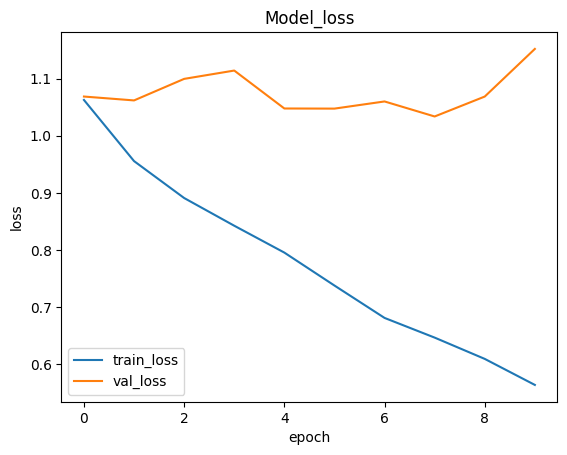

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title("Model_loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss","val_loss"])
plt.show()

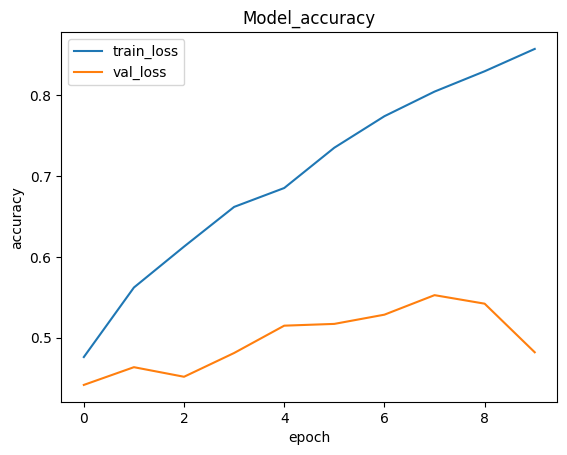

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title("Model_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_loss","val_loss"])
plt.show()

In [68]:
lenet_model.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4917 - loss: 1.1179 - top_K_accuracy: 0.7795


[1.1400142908096313, 0.48200175166130066, 0.773485541343689]

### <b> Testing </b>

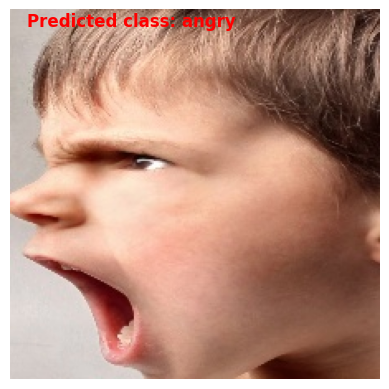

In [69]:
test_image=cv2.imread("/kaggle/input/human-emotions-datasethes/EmotionsDataset/data/angry/1.jpg")
im =tf.constant(test_image,dtype=tf.float32)
im=tf.expand_dims(im,axis=0)
predictions=lenet_model(im)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name=CLASS_NAMES[predicted_class_index]
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
plt.axis("off")

# Add the predicted class name as text on the image
plt.text(10, 10, "Predicted class: " + predicted_class_name, color='red', fontsize=12, weight='bold')

plt.show()

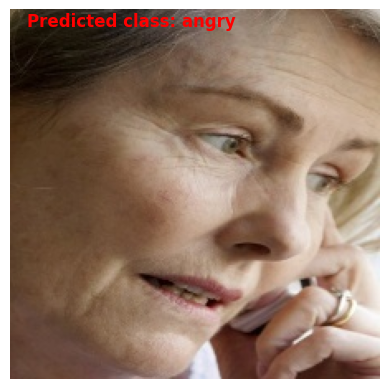

In [70]:
test_image=cv2.imread("/kaggle/input/human-emotions-datasethes/EmotionsDataset/data/happy/100.jpg")
im =tf.constant(test_image,dtype=tf.float32)
im=tf.expand_dims(im,axis=0)
predictions=lenet_model(im)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name=CLASS_NAMES[predicted_class_index]
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
plt.axis("off")

# Add the predicted class name as text on the image
plt.text(10, 10, "Predicted class: " + predicted_class_name, color='red', fontsize=12, weight='bold')

plt.show()

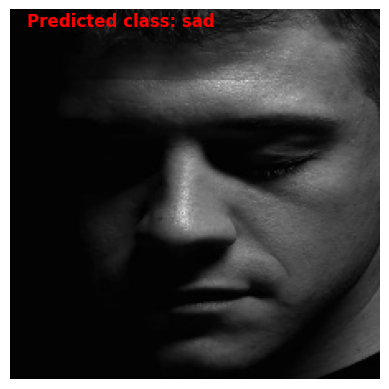

In [71]:
test_image=cv2.imread("/kaggle/input/human-emotions-datasethes/EmotionsDataset/data/sad/106.jpg")
im =tf.constant(test_image,dtype=tf.float32)
im=tf.expand_dims(im,axis=0)
predictions=lenet_model(im)
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
predicted_class_name=CLASS_NAMES[predicted_class_index]
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for Matplotlib
plt.axis("off")

# Add the predicted class name as text on the image
plt.text(10, 10, "Predicted class: " + predicted_class_name, color='red', fontsize=12, weight='bold')

plt.show()

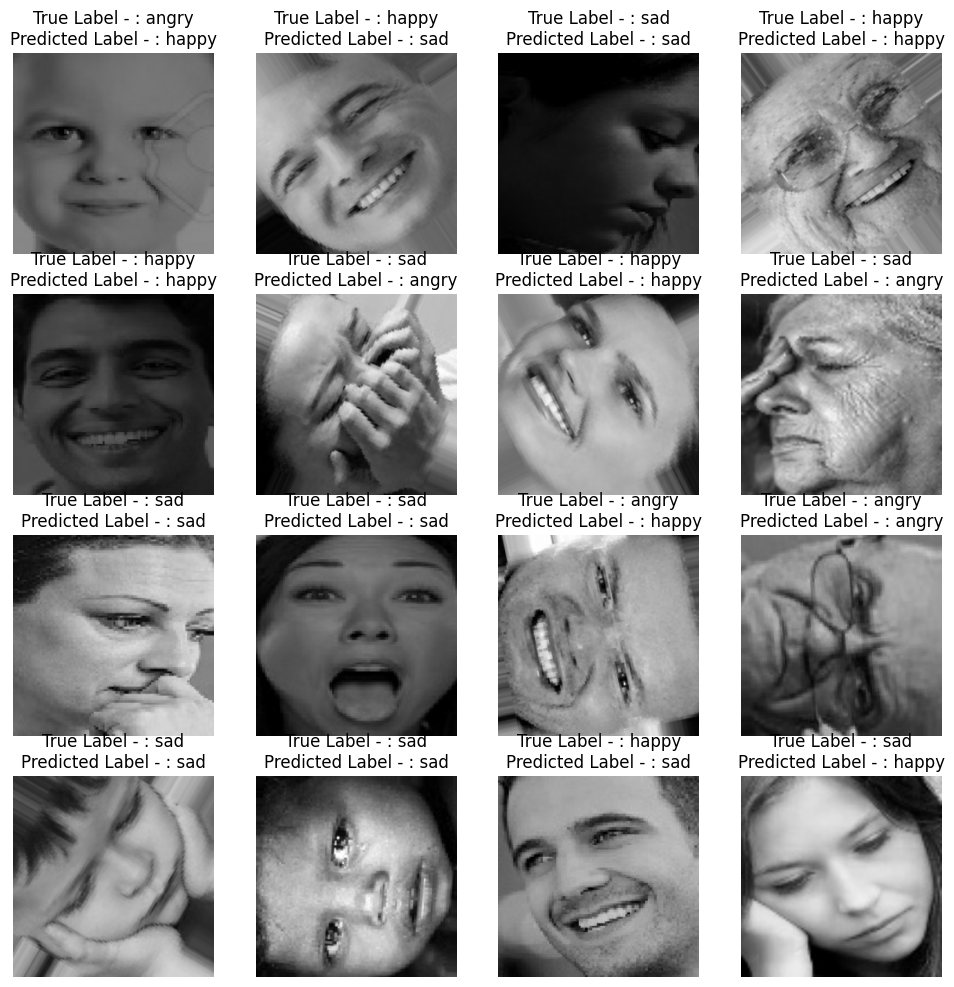

In [77]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)

    plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()] 
              + "\n" + "Predicted Label - : " 
              + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
    plt.axis("off")